# Predicting soccer outcome

<img src="http://kb4images.com/images/soccer-wallpaper/36394358-soccer-wallpaper.jpg">

Machine Learning (ML) is one the intelligent methodologies for sport prediction. In this notebook, I explain how we can apply two different ML algorithms to predict outcome of soccer matches. We have three steps to predict soccer outcome results.

1) Finding features for our model and doing some statistical analysis on the features

2) Apply Machine Learning algorithms: Logistic Regression and Support Vector Machine (SVM)

3) Optimize our model and compare it with a bookmaker results (BET365)

You can download data of English premier league 2016/2017 from:
http://football-data.co.uk/englandm.php

Notes for Football Data
<br>
HomeTeam = Home Team 
<br>
AwayTeam = Away Team
<br>
FTHG and HG = Full Time Home Team Goals
<br>
FTAG and AG = Full Time Away Team Goals
<br>
FTR and Res = Full Time Result (H=Home Win, D=Draw, A=Away Win)
<br>
HS = Home Team Shots
<br>
AS = Away Team Shots
<br>
HST = Home Team Shots on Target
<br>
AST = Away Team Shots on Target
<br>
B365H = Bet365 home win odds
<br>
B365D = Bet365 draw odds
<br>
B365A = Bet365 away win odds

In [2]:
import pandas as pd
import numpy as np
df1=pd.read_csv('E0.csv',usecols=['HomeTeam','AwayTeam','FTHG','FTAG','FTR','HS','AS','HST','AST'
,'B365H','B365D','B365A'])
df1.head()

,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,B365H,B365D,B365A
0,Burnley,Swansea,0,1,A,10,17,3,9,2.40,3.3,3.25
1,Crystal Palace,West Brom,0,1,A,14,13,4,3,2.00,3.3,4.50
2,Everton,Tottenham,1,1,D,12,13,6,4,3.20,3.4,2.40
3,Hull,Leicester,2,1,H,14,18,5,5,4.50,3.6,1.91
4,Man City,Sunderland,2,1,H,16,7,4,3,1.25,6.5,15.00


Now let's check the percentage of home win,away win and draw 

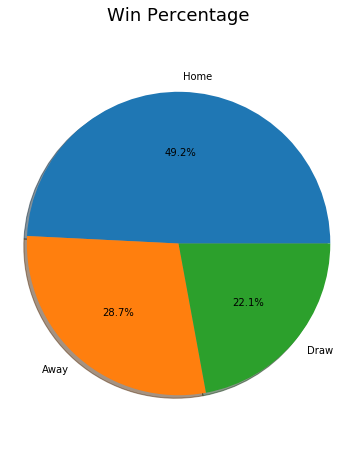

In [30]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,8))
plt.pie(df1['FTR'].value_counts(),labels=['Home','Away','Draw'], autopct='%1.1f%%',shadow=True, startangle=0)
plt.axis('equal')
plt.title('Win Percentage', size=18)
plt.show()

This pie graph shows the home team has higher chance to win the game. We can find confidence interval for our hypothesis.

In [31]:
from statsmodels.stats import proportion
conf=proportion.proportion_confint((df1['FTR']=='H').sum(), df1['FTR'].count(), alpha=0.05, method='normal')
print('The chance of home team to win with %95 confidence interval falls in :{}'.format(conf))

The chance of home team to win with %95 confidence interval falls in :(0.44183951466813098, 0.54237101164765844)


In order to have some estimation of attack, defense and possession of different team, I added another data frame to the previous data frame which can be downloaded from the following link:
http://www.squawka.com/


In [32]:
##add new data to data frame
dfSq=pd.read_csv('dataE0.csv',index_col='Team').dropna(axis=0,how='any')
##Hde: Home Defense    Hatt: Home Attack    Hpo: Home possession    Htot : Home total power  
##Ade: Away defense   Aatt: away attack    Apo : Away possession :  Atot: Away total power
dfSq.head()
dff=df1.join(dfSq[['Hde','Hatt','Hpo','Htot']],on='HomeTeam')
df=dff.join(dfSq[['Ade','Aatt','Apo','Atot']],on='AwayTeam')

Making features for our model (As an obvious fact we do not know the results for the game that we are predicting! so we need to make some features based on the previous results for every match):
<br>
1)Taking the average of previous games different features for every team and considering as a new feature for our model (For example Man City played against 10 teams in the middle of season and they had 20 shots on target, therefore we take this average (2 shots per game) and consider it as new feature)
<br>
2)I also defined a momentum which gives the average of five previous games for each team. It could be helpful to make our model more accurately. If for example some team in the five previous games shows poor results or great results, we can track them.
<br>

In [34]:
def make_data(df):
    ##add points for away and home team : win 3 points, draw 1 point, loss 0 point
    df['HP']=np.select([df['FTR']=='H',df['FTR']=='D',df['FTR']=='A'],[3,1,0])
    df['AP']=np.select([df['FTR']=='H',df['FTR']=='D',df['FTR']=='A'],[0,1,3])
    ## add difference in goals for home and away team
    df['HDG']=df['FTHG']-df['FTAG']
    df['ADG']=-df['FTHG']+df['FTAG']
    ##add momentum to data 
    cols=['Team','Points','Goal','Shoot','TargetShoot','DiffG']
    df1=df[['HomeTeam','AwayTeam','HP','AP','FTHG','FTAG','HS','AS','HST','AST','HDG','ADG']]
    df1.columns=[np.repeat(cols,2),['Home','Away']*len(cols)]
    d1=df1.stack()
    ##find momentum of previous five games for each team
    mom5 = d1.groupby('Team').apply(lambda x: x.shift().rolling(5, 4).mean())
    mom=d1.groupby('Team').apply(lambda x: pd.expanding_mean(x.shift()))
    ##add the found momentum to the dataframe
    df2=d1.assign(MP=mom5['Points'],MG=mom5['Goal'],MS=mom5['Shoot'],MST=mom5['TargetShoot'],MDG=mom5['DiffG'],AP=mom['Points'],AG=mom['Goal'],AS=mom['Shoot'],AST=mom['TargetShoot'],ADG=mom['DiffG']).unstack()
    df2=df2.drop(['Points','Goal','Shoot','TargetShoot','DiffG'],axis=1)
    df_final=pd.merge(df[['HomeTeam','AwayTeam','FTR','B365H','B365D','B365A','Ade','Aatt','Apo','Atot','Hde','Hatt','Hpo','Htot']],df2,left_on=['HomeTeam','AwayTeam'],right_on=[df2['Team']['Home'],df2['Team']['Away']])
    df_final=df_final.dropna(axis=0,how='any')
    ##Full time results ('FTR') : Home=0,Draw=1,Away=2
    Y_all=df_final['FTR']
    ##Full time results ('FTR') : Home=0,Draw=1,Away=2
    ##Prediction of betting company (bet365)=Y_Bet
    Y_Bet=df_final[['B365H','B365D','B365A']].apply(lambda x:1/x)
    ## winner based on bet365 data
    Y_Bet_FTR=np.select([Y_Bet.idxmax(axis=1)=='B365H',Y_Bet.idxmax(axis=1)=='B365D',Y_Bet.idxmax(axis=1)=='B365A'],['H','D','A'])
    ##scale data
    df_X=df_final.drop([('Team', 'Home'),('Team', 'Away'),'FTR','HomeTeam','AwayTeam','B365H','B365D','B365A'],axis=1)
    return df_X, Y_all,Y_Bet,Y_Bet_FTR
df_X, Y_all,Y_Bet,Y_Bet_FTR=make_data(df)


We have the features stored in df_X, the results stored in Y_all and results of bookmaker stored in Y_Bet_FTR. 
Then we need to scale the features.


In [35]:
from sklearn.preprocessing import scale
X_all=scale(df_X)

Then I use two different algorithms, Logistic regression and SVM, to train the models and predict the outcome. Then I defined a pipeline to optimize parameters of models (C which is optimized in these models is a parameter that shows regularization in our model)

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.metrics import classification_report
def data_split(X_all, Y_all,Y_Bet_FTR,Y_Bet):
    X_train, X_test, y_train, y_test,y_train_bet_FTR,y_test_bet_FTR,y_train_bet,y_test_bet = train_test_split(X_all, Y_all,Y_Bet_FTR,Y_Bet, test_size=0.3, random_state=42) 
    return X_train, X_test, y_train, y_test,y_train_bet_FTR,y_test_bet_FTR,y_train_bet,y_test_bet  
def predict_labels(clf,X_test):
    y_pred=clf.predict(X_test)
    return y_pred   
def report_score(clf,X_test,y_test,y_pred,X_train,y_train):
    target_names = ['H', 'D', 'A']
    print(classification_report(y_test, y_pred, target_names=target_names))
    print ('{}....Test accuracy:{} Train accuracy:{}'.format(clf.__class__.__name__,clf.score(X_test,y_test),clf.score(X_train,y_train)))
def report_score_bet365(y_test,y_pred):
    target_names = ['H', 'D', 'A']
    print(classification_report(y_test, y_pred, target_names=target_names))
    print ('BET365 accuracy:{} '.format((y_test==y_pred).sum()/len(y_test)))
def train_classifier(clf,parameters,X_train,y_train):
    grid_class = GridSearchCV(clf,scoring='accuracy',param_grid=parameters)
    grid_class = grid_class.fit(X_train,y_train)
    clf = grid_class.best_estimator_
    return clf
clf_logistic= linear_model.LogisticRegression(multi_class = "ovr", solver = 'newton-cg', class_weight = 'balanced')
clf_svc = SVC(kernel="linear",probability=True)
clfs=[clf_logistic,clf_svc]
X_train, X_test, y_train, y_test,y_train_bet_FTR,y_test_bet_FTR,y_train_bet,y_test_bet=data_split(X_all, Y_all,Y_Bet_FTR,Y_Bet)
parameter_logistic = {'C': np.logspace(-5,5,100)}
parameter_SVC = {'C': np.arange(0.1,3,0.01)}
parameters={clfs[0]:parameter_logistic,clfs[1]:parameter_SVC}

In [44]:
for clf in clfs:
    clf=train_classifier(clf,parameters[clf],X_train,y_train)
    y_pred=predict_labels(clf,X_test)
    report_score(clf,X_test,y_test,y_pred,X_train,y_train)


             precision    recall  f1-score   support

          H       0.49      0.71      0.58        28
          D       0.25      0.15      0.19        20
          A       0.71      0.65      0.68        54

avg / total       0.56      0.57      0.56       102

LogisticRegression....Test accuracy:0.5686274509803921 Train accuracy:0.6428571428571429
             precision    recall  f1-score   support

          H       0.59      0.61      0.60        28
          D       0.50      0.15      0.23        20
          A       0.64      0.80      0.71        54

avg / total       0.60      0.62      0.59       102

SVC....Test accuracy:0.6176470588235294 Train accuracy:0.6764705882352942


Let's how good, BET365 had predicted the results.

In [45]:
report_score_bet365(y_test,y_test_bet_FTR)

             precision    recall  f1-score   support

          H       0.60      0.75      0.67        28
          D       0.00      0.00      0.00        20
          A       0.67      0.83      0.74        54

avg / total       0.52      0.65      0.58       102

BET365 accuracy:0.6470588235294118 


C:\Users\Lab\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


BET365 did not have any prediction for Draw. This results in ill-defined f1-score. In general, our simple models have good accuracy and F1-score in comparison to bookmaker. We can expect this difference due to the fact that bookmakers have more data for every team and match. Therefore, they can train better prediction models. 
Also comparing Logistic regression with SVM shows that, SVM has predicted the results with higher accuracy and F1-score. 
I would like to mention that predicting betting odds is also so important. Whenever our model predicts higher probability for win or draw in comparison to bookmaker, it is logical to bet on that match (this method is referred as value bet).